## 1. Importar Librerías

In [1]:
import sys
from pathlib import Path
import json

# Add project root to path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np

from src.finetuning.hotspot_dataset import get_data_loaders
from src.finetuning.hotspot_models import get_model, get_model_info
from src.finetuning.trainer import Trainer
from src.logger_cfg.setup import setup_logging

# Setup logging
logger = setup_logging()

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070
CUDA version: 12.8


## 2. Configuración

In [2]:
# Configuración de datos
DATA_DIR = '../data/processed/hotspot_classification'
BATCH_SIZE = 32
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_WORKERS = 4
SEED = 42
IMAGE_SIZE = 224  # Ambos modelos usan 224x224

# Configuración de modelo
MODEL_TYPE = 'efficientnet_b0'  # 'efficientnet_b0' o 'densenet121'
PRETRAINED = True
FREEZE_BACKBONE = False
DROPOUT = 0.3

# Configuración de entrenamiento
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
EARLY_STOPPING = 10
CHECKPOINT_DIR = f'../models/hotspot_classification/{MODEL_TYPE}'

# Focal Loss parameters
FOCAL_LOSS_GAMMA = 2.0

# Scheduler
SCHEDULER_TYPE = 'step'  # 'step', 'cosine', 'plateau'
STEP_SIZE = 10
GAMMA = 0.1

print(f"Model: {MODEL_TYPE}")
print(f"Image size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Using Focal Loss with gamma={FOCAL_LOSS_GAMMA}")

Model: efficientnet_b0
Image size: 224
Batch size: 32
Learning rate: 0.001
Using Focal Loss with gamma=2.0


## 3. Definir Focal Loss

In [3]:
class FocalLoss(nn.Module):
    """
    Focal Loss para clasificación con desbalanceo de clases.
    
    FL(p_t) = -alpha_t * (1 - p_t)^gamma * log(p_t)
    
    Args:
        alpha: Pesos por clase (tensor)
        gamma: Factor de enfoque (default: 2.0)
        reduction: Tipo de reducción ('mean', 'sum', 'none')
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        """
        Args:
            inputs: Logits predichos [batch_size, num_classes]
            targets: Ground truth labels [batch_size]
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✓ Focal Loss definido")

✓ Focal Loss definido


## 4. Cargar Datos

In [4]:
# Cargar data loaders
train_loader, val_loader, test_loader, dataset_info = get_data_loaders(
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,
    num_workers=NUM_WORKERS,
    seed=SEED,
    augment=True
)

class_names = dataset_info['classes']

print(f"\nDataset Information:")
print(f"  Total samples: {dataset_info['total_samples']}")
print(f"  Training: {dataset_info['train_samples']}")
print(f"  Validation: {dataset_info['val_samples']}")
print(f"  Test: {dataset_info['test_samples']}")
print(f"  Classes: {class_names}")
print(f"\nClass Distribution:")
for cls, count in dataset_info['class_distribution'].items():
    percentage = (count / dataset_info['total_samples']) * 100
    print(f"  {cls}: {count} ({percentage:.1f}%)")

print(f"\nEquipment Distribution:")
for equipment, dist in dataset_info['equipment_distribution'].items():
    print(f"  {equipment}:")
    for cls, count in dist.items():
        print(f"    {cls}: {count}")

INFO - Loaded 893 images
INFO - Classes: ['no_hotspot', 'hotspot']
INFO - Dataset split: Train=626, Val=178, Test=89
INFO - Class distribution: {'no_hotspot': 247, 'hotspot': 646}

Dataset Information:
  Total samples: 893
  Training: 626
  Validation: 178
  Test: 89
  Classes: ['no_hotspot', 'hotspot']

Class Distribution:
  no_hotspot: 247 (27.7%)
  hotspot: 646 (72.3%)

Equipment Distribution:
  Circuit_Breakers:
    no_hotspot: 6
    hotspot: 197
  Power_Transformers:
    no_hotspot: 34
    hotspot: 142
  Surge_Arresters:
    no_hotspot: 89
    hotspot: 92
  Disconnectors:
    no_hotspot: 44
    hotspot: 136
  Wave_Traps:
    no_hotspot: 74
    hotspot: 79
INFO - Classes: ['no_hotspot', 'hotspot']
INFO - Dataset split: Train=626, Val=178, Test=89
INFO - Class distribution: {'no_hotspot': 247, 'hotspot': 646}

Dataset Information:
  Total samples: 893
  Training: 626
  Validation: 178
  Test: 89
  Classes: ['no_hotspot', 'hotspot']

Class Distribution:
  no_hotspot: 247 (27.7%)
  ho

## 5. Visualizar Distribución de Clases

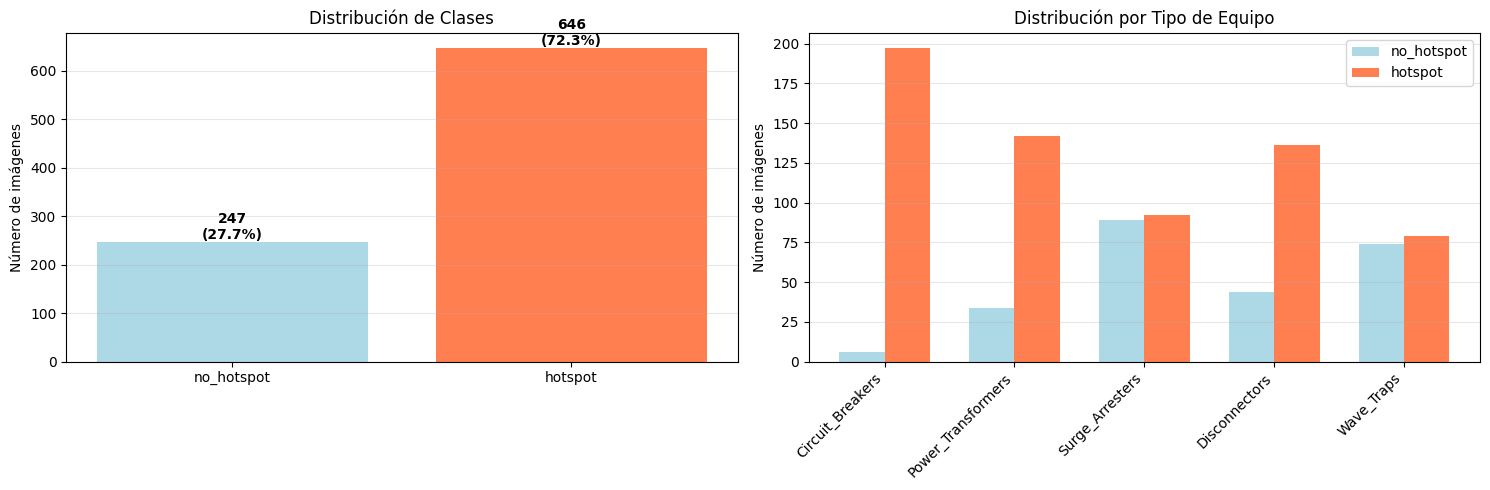


⚠ Ratio de desbalanceo: 2.62:1
  Clase mayoritaria: hotspot (646 imágenes)
  Clase minoritaria: no_hotspot (247 imágenes)


In [5]:
# Graficar distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribución general
class_counts = [dataset_info['class_distribution'][cls] for cls in class_names]
colors = ['lightblue', 'coral']
axes[0].bar(class_names, class_counts, color=colors)
axes[0].set_ylabel('Número de imágenes')
axes[0].set_title('Distribución de Clases')
axes[0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (cls, count) in enumerate(zip(class_names, class_counts)):
    percentage = (count / sum(class_counts)) * 100
    axes[0].text(i, count, f'{count}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# Distribución por equipo
equipment_types = list(dataset_info['equipment_distribution'].keys())
no_hotspot_counts = [dataset_info['equipment_distribution'][eq]['no_hotspot'] 
                     for eq in equipment_types]
hotspot_counts = [dataset_info['equipment_distribution'][eq]['hotspot'] 
                  for eq in equipment_types]

x = np.arange(len(equipment_types))
width = 0.35

axes[1].bar(x - width/2, no_hotspot_counts, width, label='no_hotspot', color='lightblue')
axes[1].bar(x + width/2, hotspot_counts, width, label='hotspot', color='coral')
axes[1].set_ylabel('Número de imágenes')
axes[1].set_title('Distribución por Tipo de Equipo')
axes[1].set_xticks(x)
axes[1].set_xticklabels(equipment_types, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar ratio de desbalanceo
ratio = max(class_counts) / min(class_counts)
print(f"\n⚠ Ratio de desbalanceo: {ratio:.2f}:1")
print(f"  Clase mayoritaria: {class_names[class_counts.index(max(class_counts))]} ({max(class_counts)} imágenes)")
print(f"  Clase minoritaria: {class_names[class_counts.index(min(class_counts))]} ({min(class_counts)} imágenes)")

## 6. Visualizar Muestras de Datos

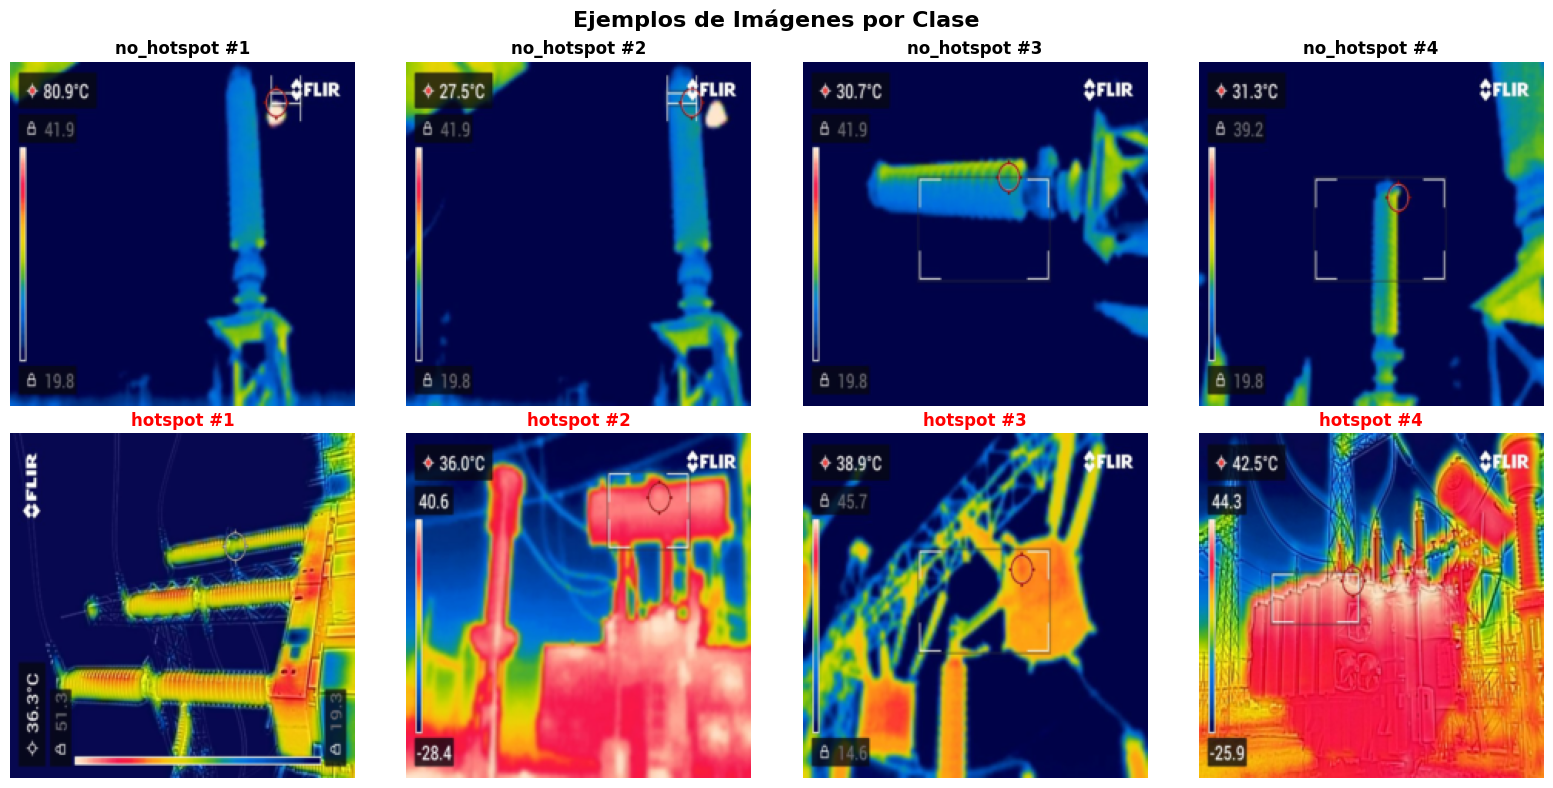

In [6]:
# Obtener un batch de cada clase
def get_samples_by_class(loader, class_idx, num_samples=4):
    samples = []
    for images, labels in loader:
        mask = labels == class_idx
        if mask.any():
            samples.extend([(img, lbl) for img, lbl in zip(images[mask], labels[mask])])
        if len(samples) >= num_samples:
            break
    return samples[:num_samples]

# Obtener muestras
no_hotspot_samples = get_samples_by_class(train_loader, 0, 4)
hotspot_samples = get_samples_by_class(train_loader, 1, 4)

# Visualizar
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Denormalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# No hotspot samples
for i, (img, lbl) in enumerate(no_hotspot_samples):
    img_np = img.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    
    axes[0, i].imshow(img_np)
    axes[0, i].set_title(f'no_hotspot #{i+1}', fontweight='bold')
    axes[0, i].axis('off')

# Hotspot samples
for i, (img, lbl) in enumerate(hotspot_samples):
    img_np = img.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    
    axes[1, i].imshow(img_np)
    axes[1, i].set_title(f'hotspot #{i+1}', fontweight='bold', color='red')
    axes[1, i].axis('off')

plt.suptitle('Ejemplos de Imágenes por Clase', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Calcular Class Weights

In [7]:
# Calcular class weights para manejar desbalanceo
class_counts = [
    dataset_info['class_distribution']['no_hotspot'],
    dataset_info['class_distribution']['hotspot']
]
total_samples = sum(class_counts)

# Peso inversamente proporcional a la frecuencia
class_weights = torch.FloatTensor([
    total_samples / (len(class_counts) * count) for count in class_counts
])

print("Class Weights calculados:")
for i, (cls, weight) in enumerate(zip(class_names, class_weights)):
    print(f"  {cls}: {weight:.4f} (count={class_counts[i]})")

print(f"\n✓ La clase minoritaria tiene {class_weights[0]/class_weights[1]:.2f}x más peso en el loss")

Class Weights calculados:
  no_hotspot: 1.8077 (count=247)
  hotspot: 0.6912 (count=646)

✓ La clase minoritaria tiene 2.62x más peso en el loss


## 8. Crear Modelo

In [8]:
# Obtener información del modelo
model_info = get_model_info(MODEL_TYPE)
if model_info:
    print(f"\nModel Information:")
    print(f"  Name: {model_info['name']}")
    print(f"  Input size: {model_info['input_size']}")
    print(f"  Parameters: {model_info['params']}")
    print(f"  Description: {model_info['description']}")

# Crear modelo
model = get_model(
    model_name=MODEL_TYPE,
    num_classes=len(class_names),
    pretrained=PRETRAINED,
    freeze_backbone=FREEZE_BACKBONE,
    dropout=DROPOUT
)

# Contar parámetros
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total_params, trainable_params = count_parameters(model)
print(f"\nParameter Count:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Frozen: {total_params - trainable_params:,}")


Model Information:
  Name: EfficientNet-B0
  Input size: 224
  Parameters: 5.3M
  Description: Compound scaling CNN with efficient architecture
INFO - Loaded pretrained EfficientNet-B0 weights

Parameter Count:
  Total: 4,010,110
  Trainable: 4,010,110
  Frozen: 0

Parameter Count:
  Total: 4,010,110
  Trainable: 4,010,110
  Frozen: 0


## 9. Configurar Optimizador, Loss y Scheduler

In [9]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
class_weights = class_weights.to(device)

# Optimizador
optimizer = Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Focal Loss con class weights
criterion = FocalLoss(alpha=class_weights, gamma=FOCAL_LOSS_GAMMA)

# Learning rate scheduler
if SCHEDULER_TYPE == 'step':
    scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
elif SCHEDULER_TYPE == 'cosine':
    from torch.optim.lr_scheduler import CosineAnnealingLR
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
elif SCHEDULER_TYPE == 'plateau':
    from torch.optim.lr_scheduler import ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
else:
    scheduler = None

print(f"\nTraining Configuration:")
print(f"  Device: {device}")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Loss: Focal Loss (gamma={FOCAL_LOSS_GAMMA})")
print(f"  Scheduler: {SCHEDULER_TYPE}")
if scheduler:
    print(f"  Scheduler params: step_size={STEP_SIZE}, gamma={GAMMA}" if SCHEDULER_TYPE == 'step' else "")


Training Configuration:
  Device: cuda
  Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 0.0001
  Loss: Focal Loss (gamma=2.0)
  Scheduler: step
  Scheduler params: step_size=10, gamma=0.1


## 10. Crear Trainer

In [10]:
# Crear directorio de checkpoint
Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)

# Crear trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    checkpoint_dir=CHECKPOINT_DIR,
    class_names=class_names,
    log_interval=10
)

print(f"✓ Trainer created")
print(f"  Checkpoint directory: {CHECKPOINT_DIR}")
print(f"  Log interval: every 10 batches")

INFO - Using device: cuda
✓ Trainer created
  Checkpoint directory: ../models/hotspot_classification/efficientnet_b0
  Log interval: every 10 batches
✓ Trainer created
  Checkpoint directory: ../models/hotspot_classification/efficientnet_b0
  Log interval: every 10 batches


## 11. Entrenar Modelo

In [11]:
# Entrenar
print(f"\n{'='*60}")
print(f"Starting training: {MODEL_TYPE}")
print(f"{'='*60}\n")

history = trainer.train(
    num_epochs=NUM_EPOCHS,
    early_stopping_patience=EARLY_STOPPING,
    save_best_only=True
)

print(f"\n{'='*60}")
print(f"Training completed!")
print(f"{'='*60}")


Starting training: efficientnet_b0

INFO - Starting training for 50 epochs
INFO - Training samples: 626
INFO - Validation samples: 178
INFO - 
Epoch 1/50
INFO - --------------------------------------------------
INFO - Training samples: 626
INFO - Validation samples: 178
INFO - 
Epoch 1/50
INFO - --------------------------------------------------
INFO -   Batch [10/20] Loss: 0.0190
INFO -   Batch [10/20] Loss: 0.0190
INFO -   Batch [20/20] Loss: 0.0359
INFO -   Batch [20/20] Loss: 0.0359
INFO - Train Loss: 0.0879, Train Acc: 0.8403
INFO - Train Loss: 0.0879, Train Acc: 0.8403
INFO - Val Loss: 0.0745, Val Acc: 0.9382
INFO - 
Per-class metrics:
INFO -   no_hotspot: P=0.885, R=0.902, F1=0.893, N=51
INFO -   hotspot: P=0.960, R=0.953, F1=0.957, N=127
INFO - Validation accuracy improved from 0.0000 to 0.9382
INFO - Val Loss: 0.0745, Val Acc: 0.9382
INFO - 
Per-class metrics:
INFO -   no_hotspot: P=0.885, R=0.902, F1=0.893, N=51
INFO -   hotspot: P=0.960, R=0.953, F1=0.957, N=127
INFO - Val

## 12. Visualizar Resultados de Entrenamiento

In [12]:
# Graficar historial de entrenamiento
trainer.plot_history(save_path=f'{CHECKPOINT_DIR}/training_history.png')
plt.show()

# Mostrar estadísticas finales
print(f"\nFinal Training Statistics:")
print(f"  Best validation accuracy: {trainer.best_val_acc:.4f}")
print(f"  Best epoch: {history['train_loss'].index(min(history['train_loss'])) + 1}")
print(f"  Total epochs trained: {len(history['train_loss'])}")

# Mostrar learning rates si hay scheduler
if 'learning_rates' in history and history['learning_rates']:
    print(f"  Initial LR: {history['learning_rates'][0]:.6f}")
    print(f"  Final LR: {history['learning_rates'][-1]:.6f}")

INFO - Saved training history plot to ../models/hotspot_classification/efficientnet_b0/training_history.png

Final Training Statistics:
  Best validation accuracy: 0.9831
  Best epoch: 14
  Total epochs trained: 19
  Initial LR: 0.001000
  Final LR: 0.000100

Final Training Statistics:
  Best validation accuracy: 0.9831
  Best epoch: 14
  Total epochs trained: 19
  Initial LR: 0.001000
  Final LR: 0.000100


## 13. Evaluar en Conjunto de Test

In [13]:
# Evaluar en test set
print(f"\n{'='*60}")
print(f"Evaluating on test set...")
print(f"{'='*60}\n")

model.eval()
test_running_loss = 0.0
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        test_running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss = test_running_loss / len(test_loader.dataset)

# Calcular métricas
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

test_acc = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    test_labels, test_preds, average='weighted', zero_division=0
)
cm = confusion_matrix(test_labels, test_preds)

test_metrics = {
    'accuracy': float(test_acc),
    'precision': float(precision),
    'recall': float(recall),
    'f1': float(f1),
    'loss': float(test_loss),
    'confusion_matrix': cm.tolist()
}

print(f"Test Results:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Loss: {test_loss:.4f}")

# Métricas por clase
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    test_labels, test_preds, average=None, zero_division=0
)

print(f"\nPer-class metrics:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}:")
    print(f"    Precision: {precision_per_class[i]:.3f}")
    print(f"    Recall: {recall_per_class[i]:.3f}")
    print(f"    F1-score: {f1_per_class[i]:.3f}")
    print(f"    Support: {support_per_class[i]}")


Evaluating on test set...

Test Results:
  Accuracy: 0.9326
  Precision: 0.9461
  Recall: 0.9326
  F1-Score: 0.9347
  Loss: 0.0898

Per-class metrics:
  no_hotspot:
    Precision: 0.800
    Recall: 1.000
    F1-score: 0.889
    Support: 24
  hotspot:
    Precision: 1.000
    Recall: 0.908
    F1-score: 0.952
    Support: 65
Test Results:
  Accuracy: 0.9326
  Precision: 0.9461
  Recall: 0.9326
  F1-Score: 0.9347
  Loss: 0.0898

Per-class metrics:
  no_hotspot:
    Precision: 0.800
    Recall: 1.000
    F1-score: 0.889
    Support: 24
  hotspot:
    Precision: 1.000
    Recall: 0.908
    F1-score: 0.952
    Support: 65


## 14. Visualizar Matriz de Confusión

In [14]:
# Graficar matriz de confusión
trainer.plot_confusion_matrix(test_metrics, save_path=f'{CHECKPOINT_DIR}/confusion_matrix.png')
plt.show()

# Análisis de la matriz de confusión
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Analysis:")
print(f"  True Negatives (no_hotspot correctly predicted): {tn}")
print(f"  False Positives (no_hotspot predicted as hotspot): {fp}")
print(f"  False Negatives (hotspot predicted as no_hotspot): {fn}")
print(f"  True Positives (hotspot correctly predicted): {tp}")
print(f"\n  Specificity (TN/(TN+FP)): {tn/(tn+fp):.4f}")
print(f"  Sensitivity/Recall (TP/(TP+FN)): {tp/(tp+fn):.4f}")

INFO - Saved confusion matrix to ../models/hotspot_classification/efficientnet_b0/confusion_matrix.png

Confusion Matrix Analysis:
  True Negatives (no_hotspot correctly predicted): 24
  False Positives (no_hotspot predicted as hotspot): 0
  False Negatives (hotspot predicted as no_hotspot): 6
  True Positives (hotspot correctly predicted): 59

  Specificity (TN/(TN+FP)): 1.0000
  Sensitivity/Recall (TP/(TP+FN)): 0.9077

Confusion Matrix Analysis:
  True Negatives (no_hotspot correctly predicted): 24
  False Positives (no_hotspot predicted as hotspot): 0
  False Negatives (hotspot predicted as no_hotspot): 6
  True Positives (hotspot correctly predicted): 59

  Specificity (TN/(TN+FP)): 1.0000
  Sensitivity/Recall (TP/(TP+FN)): 0.9077


## 15. Guardar Métricas

In [15]:
# Guardar métricas de test en JSON
metrics_path = Path(CHECKPOINT_DIR) / 'test_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(test_metrics, f, indent=2)

print(f"✓ Test metrics saved to: {metrics_path}")
print(f"\nTest Metrics JSON:")
print(json.dumps(test_metrics, indent=2))

✓ Test metrics saved to: ../models/hotspot_classification/efficientnet_b0/test_metrics.json

Test Metrics JSON:
{
  "accuracy": 0.9325842696629213,
  "precision": 0.9460674157303371,
  "recall": 0.9325842696629213,
  "f1": 0.9346985622810197,
  "loss": 0.08976995582127253,
  "confusion_matrix": [
    [
      24,
      0
    ],
    [
      6,
      59
    ]
  ]
}


## 16. Inferencia en Nuevas Imágenes


Ejemplos de predicción:

Ejemplo 1: Imagen SIN hotspot

Image: ../data/processed/hotspot_classification/Circuit_Breakers/no_hotspot/FLIR4534.jpg
Prediction: no_hotspot
Confidence: 95.58%

Probabilities:
  no_hotspot: 95.58%
  hotspot: 4.42%

Image: ../data/processed/hotspot_classification/Circuit_Breakers/no_hotspot/FLIR4534.jpg
Prediction: no_hotspot
Confidence: 95.58%

Probabilities:
  no_hotspot: 95.58%
  hotspot: 4.42%


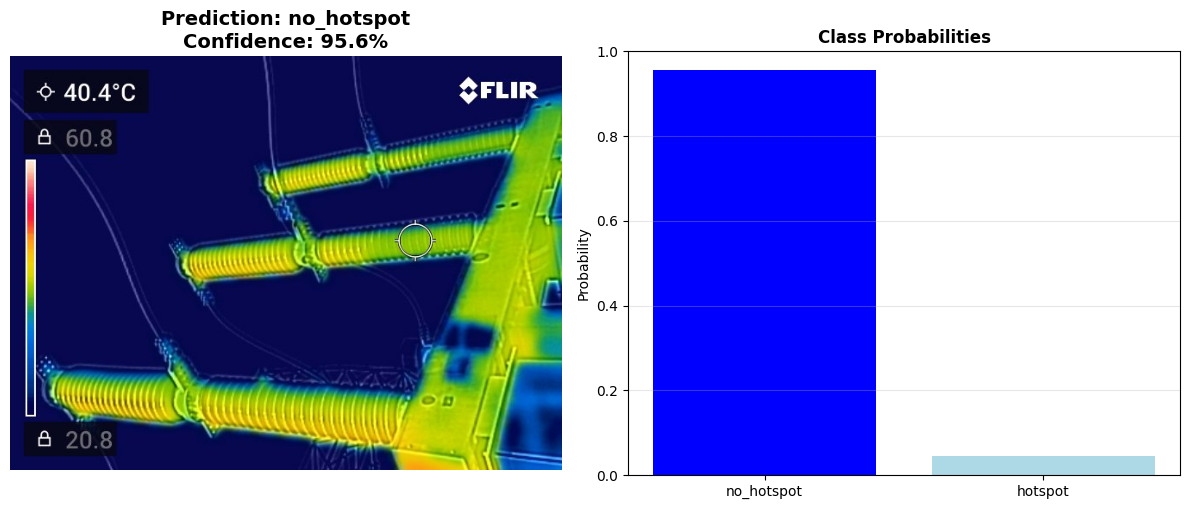


Ejemplo 2: Imagen CON hotspot

Image: ../data/processed/hotspot_classification/Circuit_Breakers/hotspot/FLIR4430.jpg
Prediction: hotspot
Confidence: 92.04%

Probabilities:
  no_hotspot: 7.96%
  hotspot: 92.04%


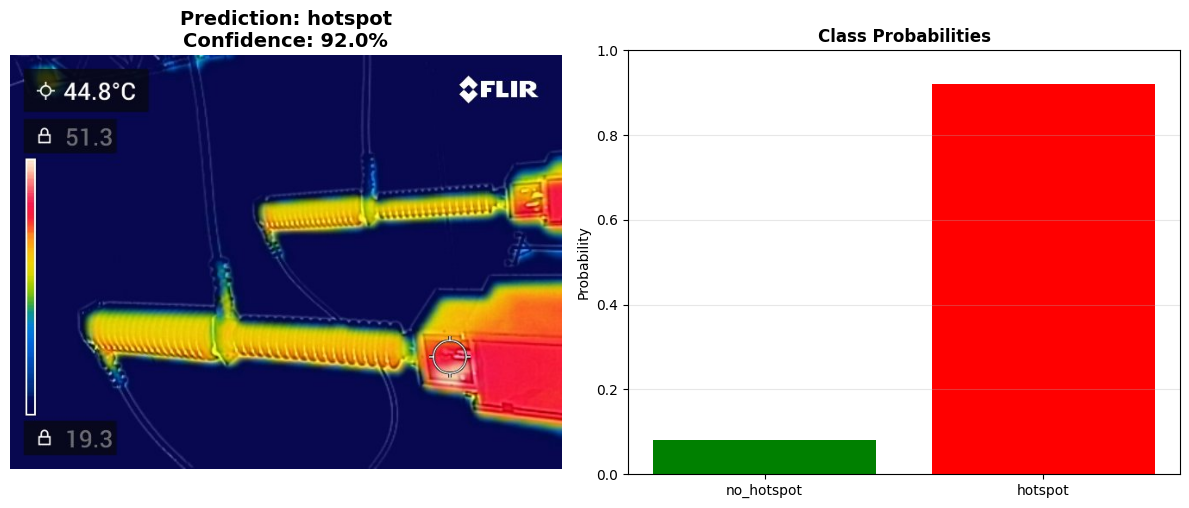

In [16]:
from PIL import Image
from torchvision import transforms

# Definir transform para inferencia
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def predict_hotspot(image_path, model, class_names, device, show_image=True):
    """Predict if image has hotspot."""
    # Cargar imagen
    image = Image.open(image_path).convert('RGB')
    
    # Aplicar transform
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predicción
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]
    
    pred_class = class_names[torch.argmax(probabilities).item()]
    confidence = probabilities.max().item()
    
    print(f"\nImage: {image_path}")
    print(f"Prediction: {pred_class}")
    print(f"Confidence: {confidence*100:.2f}%")
    print(f"\nProbabilities:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {probabilities[i]*100:.2f}%")
    
    if show_image:
        # Visualizar
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Imagen
        axes[0].imshow(image)
        axes[0].set_title(f'Prediction: {pred_class}\nConfidence: {confidence*100:.1f}%', 
                         fontweight='bold', fontsize=14)
        axes[0].axis('off')
        
        # Probabilidades
        colors = ['green' if pred_class == 'hotspot' else 'blue',
                  'red' if pred_class == 'hotspot' else 'lightblue']
        axes[1].bar(class_names, probabilities.cpu().numpy(), color=colors)
        axes[1].set_ylabel('Probability')
        axes[1].set_title('Class Probabilities', fontweight='bold')
        axes[1].set_ylim([0, 1])
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return pred_class, confidence

# Ejemplo de uso con imágenes de test
print("\nEjemplos de predicción:\n")

# Predecir una imagen sin hotspot
no_hotspot_images = list(Path(DATA_DIR).rglob('no_hotspot/*.jpg'))
if no_hotspot_images:
    print("="*60)
    print("Ejemplo 1: Imagen SIN hotspot")
    print("="*60)
    pred_class, confidence = predict_hotspot(no_hotspot_images[0], model, class_names, device)

# Predecir una imagen con hotspot
hotspot_images = list(Path(DATA_DIR).rglob('hotspot/*.jpg'))
if hotspot_images:
    print("\n" + "="*60)
    print("Ejemplo 2: Imagen CON hotspot")
    print("="*60)
    pred_class, confidence = predict_hotspot(hotspot_images[0], model, class_names, device)

## 17. Cargar Modelo Guardado

In [17]:
def load_trained_model(checkpoint_path, device=None):
    """Load a trained model from checkpoint."""
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    device = torch.device(device)
    
    # Cargar checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Obtener información
    class_names = checkpoint['class_names']
    num_classes = len(class_names)
    
    # Determinar tipo de modelo del path
    if 'efficientnet' in str(checkpoint_path).lower():
        model_name = 'efficientnet_b0'
    elif 'densenet' in str(checkpoint_path).lower():
        model_name = 'densenet121'
    else:
        raise ValueError(f"Cannot determine model type from path: {checkpoint_path}")
    
    # Crear y cargar modelo
    model = get_model(model_name, num_classes, pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✓ Loaded {model_name} model")
    print(f"  Classes: {class_names}")
    print(f"  Best validation accuracy: {checkpoint['best_val_acc']:.4f}")
    print(f"  Device: {device}")
    
    return model, class_names, device

# Ejemplo de uso
# checkpoint_path = '../models/hotspot_classification/efficientnet_b0/best_model.pth'
# model, class_names, device = load_trained_model(checkpoint_path)

## 18. Limpieza de GPU

In [18]:
# Liberar memoria GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✓ GPU cache cleared")
    
    # Mostrar memoria GPU
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"\nGPU Memory:")
    print(f"  Allocated: {allocated:.2f} GB")
    print(f"  Reserved: {reserved:.2f} GB")

✓ GPU cache cleared

GPU Memory:
  Allocated: 0.11 GB
  Reserved: 0.19 GB


## Conclusión

Este notebook demostró el proceso completo de fine-tuning para clasificación de hotspots:

### ✓ Logros:
1. **Manejo de datos desbalanceados** mediante Focal Loss y class weights
2. **Visualización de distribución** de clases y equipos
3. **Entrenamiento robusto** con early stopping y LR scheduling
4. **Evaluación completa** con métricas detalladas por clase
5. **Inferencia lista** para nuevas imágenes

### 📊 Métricas Clave:
- **Focal Loss**: Enfoca aprendizaje en ejemplos difíciles
- **Class Weights**: Balancea contribución de cada clase
- **Confusion Matrix**: Analiza tipos de errores
- **Per-class Metrics**: Rendimiento individual por clase

### 🚀 Próximos Pasos:
- Experimentar con diferentes valores de `gamma` en Focal Loss
- Probar ensemble de EfficientNet-B0 y DenseNet-121
- Implementar detección de hotspots con bounding boxes
- Aplicar técnicas de interpretabilidad (Grad-CAM)
- Fine-tuning en dos fases (congelar/descongelar backbone)

### 💾 Archivos Generados:
- `best_model.pth`: Mejor modelo según validation accuracy
- `training_history.png`: Gráficas de loss y accuracy
- `confusion_matrix.png`: Matriz de confusión en test set
- `test_metrics.json`: Métricas detalladas en formato JSON